## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2, l1_l2

def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio,l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio,l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2_EXP = [[1e-2,1e-2],[1e-4,1e-2],[1e-2,1e-4],[1e-4,1e-4]]
drp_ratio=0.25

In [7]:
results = {}

for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
#     print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio[0],l2_ratio=regulizer_ratio[1])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 

50000/50000 [==============================] - 8s 159us/step - loss: 2.3684 - accuracy: 0.2222 - val_loss: 2.4541 - val_accuracy: 0.1847
Epoch 44/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.3586 - accuracy: 0.2269 - val_loss: 2.4204 - val_accuracy: 0.1680
Epoch 45/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.3648 - accuracy: 0.2179 - val_loss: 2.4029 - val_accuracy: 0.1918
Epoch 46/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.3688 - accuracy: 0.2264 - val_loss: 2.3566 - val_accuracy: 0.2002
Epoch 47/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.3549 - accuracy: 0.2267 - val_loss: 2.4608 - val_accuracy: 0.2009
Epoch 48/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.3552 - accuracy: 0.2313 - val_loss: 2.4164 - val_accuracy: 0.2075
Epoch 49/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.3534 - accuracy: 0.2326 - val_loss:

50000/50000 [==============================] - 8s 161us/step - loss: 3.5476 - accuracy: 0.4714 - val_loss: 3.5142 - val_accuracy: 0.4749
Epoch 36/50
50000/50000 [==============================] - 8s 161us/step - loss: 3.5069 - accuracy: 0.4684 - val_loss: 3.4726 - val_accuracy: 0.4715
Epoch 37/50
50000/50000 [==============================] - 8s 160us/step - loss: 3.4611 - accuracy: 0.4673 - val_loss: 3.4544 - val_accuracy: 0.4584
Epoch 38/50
50000/50000 [==============================] - 8s 161us/step - loss: 3.4055 - accuracy: 0.4736 - val_loss: 3.3971 - val_accuracy: 0.4760
Epoch 39/50
50000/50000 [==============================] - 8s 161us/step - loss: 3.3839 - accuracy: 0.4679 - val_loss: 3.3150 - val_accuracy: 0.4889
Epoch 40/50
50000/50000 [==============================] - 8s 165us/step - loss: 3.3273 - accuracy: 0.4711 - val_loss: 3.3248 - val_accuracy: 0.4731
Epoch 41/50
50000/50000 [==============================] - 9s 177us/step - loss: 3.2885 - accuracy: 0.4716 - val_loss:

50000/50000 [==============================] - 8s 161us/step - loss: 1.4282 - accuracy: 0.4878 - val_loss: 1.4067 - val_accuracy: 0.4976
Epoch 28/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.4289 - accuracy: 0.4871 - val_loss: 1.4083 - val_accuracy: 0.4976
Epoch 29/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.4288 - accuracy: 0.4832 - val_loss: 1.4461 - val_accuracy: 0.4812
Epoch 30/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.4157 - accuracy: 0.4890 - val_loss: 1.3982 - val_accuracy: 0.5034
Epoch 31/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.4125 - accuracy: 0.4923 - val_loss: 1.3917 - val_accuracy: 0.5019
Epoch 32/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.4034 - accuracy: 0.4940 - val_loss: 1.3763 - val_accuracy: 0.5085
Epoch 33/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4042 - accuracy: 0.4932 - val_loss:

50000/50000 [==============================] - 8s 162us/step - loss: 1.4810 - accuracy: 0.4670 - val_loss: 1.4206 - val_accuracy: 0.4826
Epoch 20/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4729 - accuracy: 0.4703 - val_loss: 1.4246 - val_accuracy: 0.4815
Epoch 21/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4645 - accuracy: 0.4743 - val_loss: 1.4097 - val_accuracy: 0.4938
Epoch 22/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.4575 - accuracy: 0.4772 - val_loss: 1.4168 - val_accuracy: 0.4994
Epoch 23/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4557 - accuracy: 0.4771 - val_loss: 1.4035 - val_accuracy: 0.4999
Epoch 24/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4479 - accuracy: 0.4778 - val_loss: 1.4384 - val_accuracy: 0.4880
Epoch 25/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4480 - accuracy: 0.4802 - val_loss:

50000/50000 [==============================] - 8s 159us/step - loss: 4.3749 - accuracy: 0.4142 - val_loss: 4.1061 - val_accuracy: 0.4454
Epoch 12/50
50000/50000 [==============================] - 8s 161us/step - loss: 3.9687 - accuracy: 0.4240 - val_loss: 3.7964 - val_accuracy: 0.4225
Epoch 13/50
50000/50000 [==============================] - 9s 173us/step - loss: 3.6237 - accuracy: 0.4286 - val_loss: 3.4568 - val_accuracy: 0.4388
Epoch 14/50
50000/50000 [==============================] - 9s 172us/step - loss: 3.3454 - accuracy: 0.4256 - val_loss: 3.2424 - val_accuracy: 0.4070
Epoch 15/50
50000/50000 [==============================] - 9s 173us/step - loss: 3.0977 - accuracy: 0.4269 - val_loss: 2.9923 - val_accuracy: 0.4270
Epoch 16/50
50000/50000 [==============================] - 8s 163us/step - loss: 2.8898 - accuracy: 0.4272 - val_loss: 2.8476 - val_accuracy: 0.4036
Epoch 17/50
50000/50000 [==============================] - 8s 158us/step - loss: 2.7104 - accuracy: 0.4245 - val_loss:

50000/50000 [==============================] - 8s 155us/step - loss: 1.9897 - accuracy: 0.3419 - val_loss: 1.8016 - val_accuracy: 0.4010
Epoch 4/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.9176 - accuracy: 0.3642 - val_loss: 1.7661 - val_accuracy: 0.4188
Epoch 5/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.8555 - accuracy: 0.3845 - val_loss: 1.7465 - val_accuracy: 0.4176
Epoch 6/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.8253 - accuracy: 0.3953 - val_loss: 1.7790 - val_accuracy: 0.4151
Epoch 7/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.7980 - accuracy: 0.4041 - val_loss: 1.7113 - val_accuracy: 0.4440
Epoch 8/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.7763 - accuracy: 0.4154 - val_loss: 1.6889 - val_accuracy: 0.4492
Epoch 9/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.7472 - accuracy: 0.4211 - val_loss: 1.651

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.3291 - accuracy: 0.2309 - val_loss: 1.8831 - val_accuracy: 0.3212
Epoch 2/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.9754 - accuracy: 0.3017 - val_loss: 1.7442 - val_accuracy: 0.3751
Epoch 3/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.8473 - accuracy: 0.3400 - val_loss: 1.6572 - val_accuracy: 0.4083
Epoch 4/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.7731 - accuracy: 0.3641 - val_loss: 1.6272 - val_accuracy: 0.4200
Epoch 5/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.7224 - accuracy: 0.3807 - val_loss: 1.6012 - val_accuracy: 0.4307
Epoch 6/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.6873 - accuracy: 0.3943 - val_loss: 1.5589 - val_accuracy: 0.4471
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 173us/step - loss: 2.3413 - accuracy: 0.2266 - val_loss: 1.8603 - val_accuracy: 0.3453
Epoch 2/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.9820 - accuracy: 0.3036 - val_loss: 1.8059 - val_accuracy: 0.3502
Epoch 3/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.8544 - accuracy: 0.3374 - val_loss: 1.6680 - val_accuracy: 0.4070
Epoch 4/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.7780 - accuracy: 0.3633 - val_loss: 1.6099 - val_accuracy: 0.4240
Epoch 5/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.7314 - accuracy: 0.3797 - val_loss: 1.5954 - val_accuracy: 0.4305
Epoch 6/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.6878 - accuracy: 0.3933 - val_loss: 1.5831 - val_accuracy: 0.4305
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 167us/step - loss: 197.7881 - accuracy: 0.2346 - val_loss: 35.8344 - val_accuracy: 0.2462
Epoch 2/50
50000/50000 [==============================] - 8s 163us/step - loss: 15.8784 - accuracy: 0.1099 - val_loss: 5.1622 - val_accuracy: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 162us/step - loss: 3.2214 - accuracy: 0.0979 - val_loss: 2.4715 - val_accuracy: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 162us/step - loss: 2.4631 - accuracy: 0.1000 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 162us/step - loss: 2.4624 - accuracy: 0.0966 - val_loss: 2.4623 - val_accuracy: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 162us/step - loss: 2.4624 - accuracy: 0.0969 - val_loss: 2.4623 - val_accuracy: 0.1000
Epoch 7/50
50000/50000 [==============================] - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 183us/step - loss: 18.8033 - accuracy: 0.2648 - val_loss: 17.3648 - val_accuracy: 0.3386
Epoch 2/50
50000/50000 [==============================] - 9s 178us/step - loss: 16.1464 - accuracy: 0.3550 - val_loss: 14.9800 - val_accuracy: 0.3671
Epoch 3/50
50000/50000 [==============================] - 9s 179us/step - loss: 13.9586 - accuracy: 0.3768 - val_loss: 12.9745 - val_accuracy: 0.3824
Epoch 4/50
50000/50000 [==============================] - 9s 178us/step - loss: 12.1098 - accuracy: 0.3903 - val_loss: 11.2736 - val_accuracy: 0.4001
Epoch 5/50
50000/50000 [==============================] - 9s 178us/step - loss: 10.5378 - accuracy: 0.3997 - val_loss: 9.8294 - val_accuracy: 0.4006
Epoch 6/50
50000/50000 [==============================] - 9s 184us/step - loss: 9.2014 - accuracy: 0.4073 - val_loss: 8.5944 - val_accuracy: 0.4114
Epoch 7/50
50000/50000 [=============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 183us/step - loss: 198.6623 - accuracy: 0.2422 - val_loss: 40.9804 - val_accuracy: 0.2519
Epoch 2/50
50000/50000 [==============================] - 9s 178us/step - loss: 19.0222 - accuracy: 0.1170 - val_loss: 7.2349 - val_accuracy: 0.1000
Epoch 3/50
50000/50000 [==============================] - 9s 177us/step - loss: 4.0891 - accuracy: 0.0988 - val_loss: 2.6465 - val_accuracy: 0.1000
Epoch 4/50
50000/50000 [==============================] - 9s 180us/step - loss: 2.4865 - accuracy: 0.0965 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 5/50
50000/50000 [==============================] - 9s 177us/step - loss: 2.4626 - accuracy: 0.0984 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 2.4626 - accuracy: 0.0980 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 7/50
50000/50000 [==============================] - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 182us/step - loss: 6.1302 - accuracy: 0.2793 - val_loss: 5.9333 - val_accuracy: 0.3430
Epoch 2/50
50000/50000 [==============================] - 9s 177us/step - loss: 5.8391 - accuracy: 0.3687 - val_loss: 5.7584 - val_accuracy: 0.3834
Epoch 3/50
50000/50000 [==============================] - 9s 177us/step - loss: 5.6859 - accuracy: 0.3995 - val_loss: 5.6242 - val_accuracy: 0.4074
Epoch 4/50
50000/50000 [==============================] - 9s 176us/step - loss: 5.5592 - accuracy: 0.4205 - val_loss: 5.5174 - val_accuracy: 0.4191
Epoch 5/50
50000/50000 [==============================] - 9s 177us/step - loss: 5.4453 - accuracy: 0.4354 - val_loss: 5.4115 - val_accuracy: 0.4282
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 5.3415 - accuracy: 0.4463 - val_loss: 5.3109 - val_accuracy: 0.4439
Epoch 7/50
50000/50000 [==============================] - 9s 1

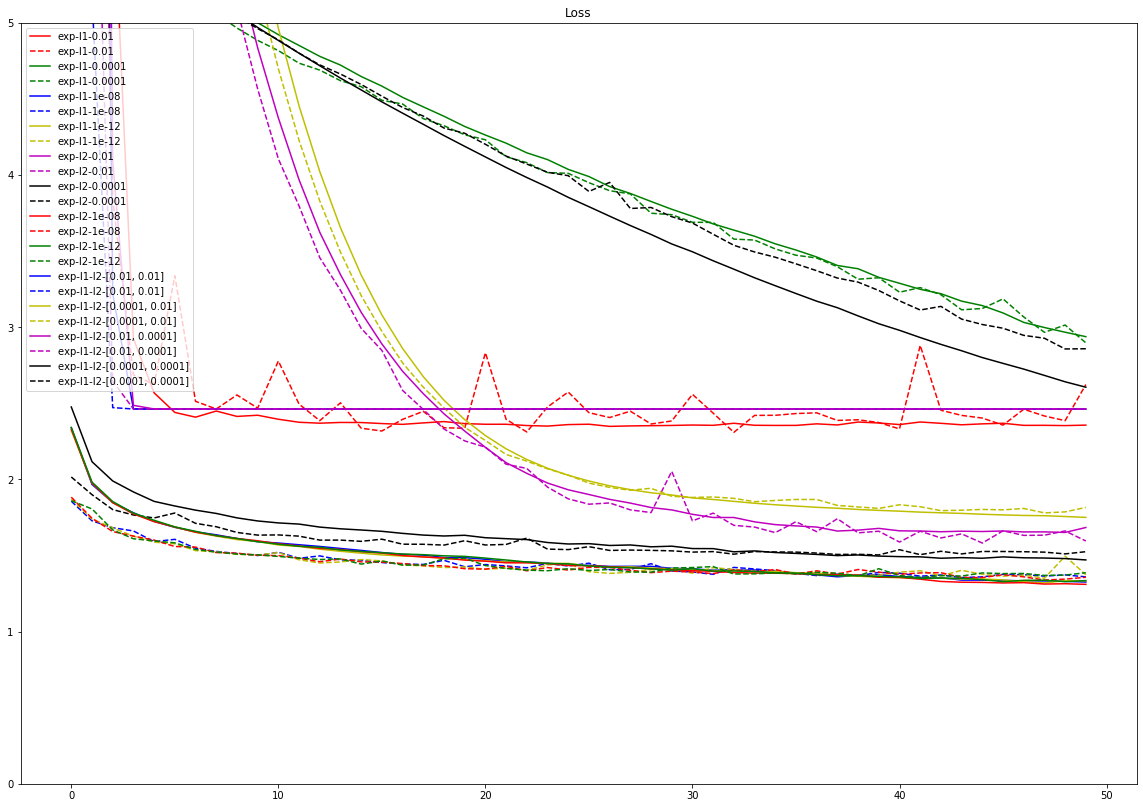

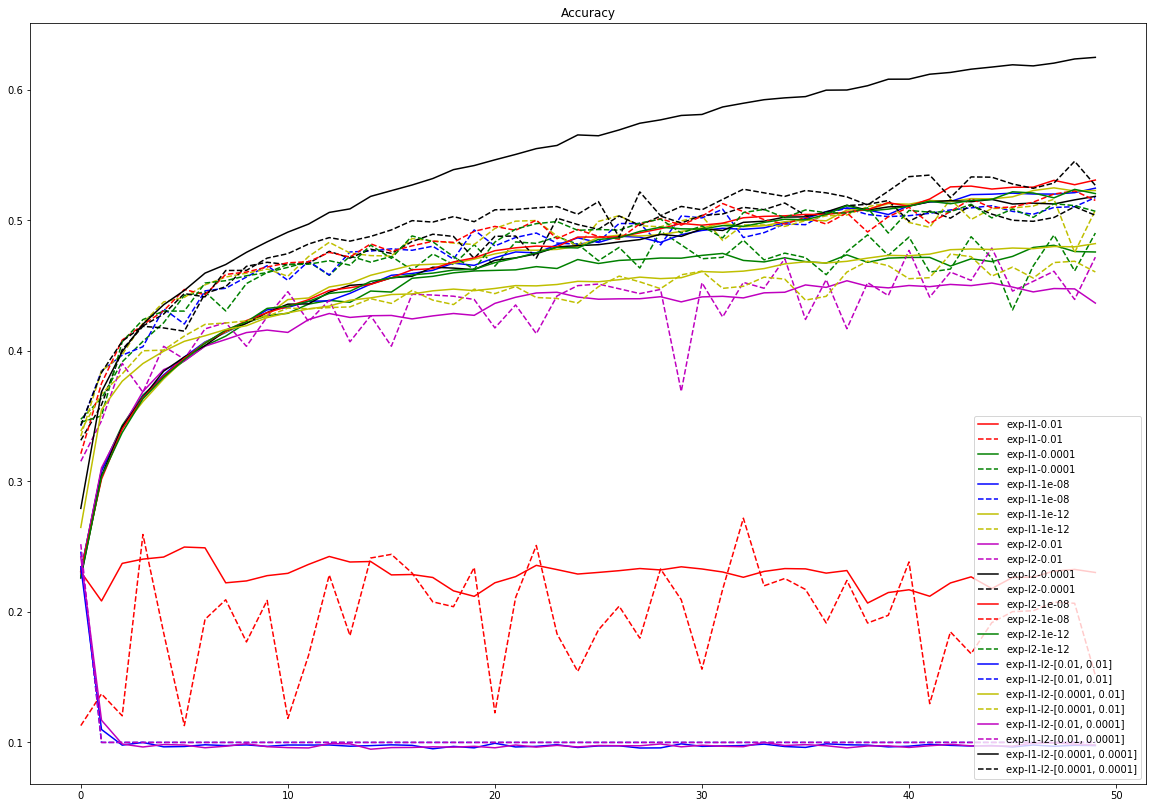

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","r", "g", "b", "y", "m", "k","r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(20,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()